In [1]:
#直接分类
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%config InlineBackend.figure_format = 'svg'
rock_character = pd.read_excel('../data/模型数据副本.xlsx',sheet_name = '材料')
device_wob = pd.read_excel('../data/模型数据副本.xlsx',sheet_name = '设备wob')
device_T = pd.read_excel('../data/模型数据副本.xlsx',sheet_name = '设备T')
device_S = pd.read_excel('../data/模型数据副本.xlsx',sheet_name = '设备S')
device_Z = pd.read_excel('../data/模型数据副本.xlsx',sheet_name = '设备Z')
device_wob['time'] = [int(temp) for temp in device_wob['时间/s']]
device_T['time'] = [int(temp) for temp in device_T['时间/s']]
device_wob.head(n=10)
del device_wob['时间/s']
del device_T['时间/s']
columns = ['材料2','材料4','材料5','材料7','材料8','材料10','材料11','材料13','材料55','材料21','材料22']
res_df = pd.DataFrame(columns=['wob_min','wob_max','wob_mean','wob_std','wob_skew','wob_kuet','T_min','T_max','T_mean','T_std','T_skew','T_kuet','S','Z','res'])

for time in range(1050,1406,3):
    device_wob_temp = device_wob[(device_wob['time']>=time) & (device_wob['time']<(time+3))]
    device_T_temp = device_T[(device_T['time']>=time) & (device_T['time']<(time+3))]
    
    device_wob_temp_des = device_wob_temp[columns].describe()
    device_T_temp_des = device_T_temp[columns].describe()
    
    #每三钟算一组，统计特征,取少的这个device_T_mean
    for column in columns:
        wob_min = device_wob_temp_des[column]['min']
        wob_max = device_wob_temp_des[column]['max']
        wob_mean = device_wob_temp_des[column]['mean']
        wob_std = device_wob_temp_des[column]['std']
        wob_skew = device_wob_temp[column].skew()#偏度计算
        wob_kuet = device_wob_temp[column].kurt()#峰度计算        

        T_min = device_T_temp_des[column]['min']
        T_max = device_T_temp_des[column]['max']
        T_mean = device_T_temp_des[column]['mean']
        T_std = device_T_temp_des[column]['std']
        T_skew = device_T_temp[column].skew()#偏度计算
        T_kuet = device_T_temp[column].kurt()#峰度计算  


        S = device_S[column].values[0]
        Z = device_Z[column].values[0]
        res = column
        row = {'wob_min':wob_min,'wob_max':wob_max,'wob_mean':wob_mean,'wob_std':wob_std,'wob_skew':wob_skew,'wob_kuet':wob_kuet,'T_min':T_min,'T_max':T_max,'T_mean':T_mean,'T_std':T_std,'T_skew':T_skew,'T_kuet':T_kuet,'S':S,'Z':Z,'res':res}
        res_df.loc[len(res_df)] = row

res_df.head()

,wob_min,wob_max,wob_mean,wob_std,wob_skew,wob_kuet,T_min,T_max,T_mean,T_std,T_skew,T_kuet,S,Z,res
0,3.00286,3.65089,3.413814,0.236150,-1.001939,-0.280232,7.998,11.970,10.1435,1.191906,-0.029635,-0.159510,101.4,2.4,材料2
1,3.80704,4.15474,3.976719,0.126295,0.100818,-1.554364,8.413,10.248,9.3901,0.607808,-0.250214,-1.231008,71.5,2.8,材料4
2,4.08101,4.31455,4.213552,0.081998,-0.459574,-1.095551,15.572,18.853,16.9028,1.003761,0.619745,-0.064846,67.9,2.6,材料5
3,3.26430,5.01131,4.058786,0.532198,0.146446,-0.403349,5.894,9.269,6.8684,1.142407,1.465707,1.058720,65.7,"1,7",材料7
4,3.75266,3.96912,3.857168,0.071982,0.244940,-1.211552,12.974,14.166,13.4431,0.452866,0.748555,-0.928809,72.9,2.9,材料8


In [2]:
# xgboost分类器
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
xxx = ['wob_min','wob_max','wob_mean','wob_std','wob_skew','wob_kuet','T_min','T_max','T_mean','T_std','T_skew','T_kuet']
X = res_df[xxx]

y_encoded = le.fit_transform(res_df['res'])
res_df['label'] = y_encoded
Y = res_df['label']

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score # 衡量模型的优劣
# 随机采样20%的数据构建测试样本，其余作为训练样本
Xtrain1, Xtest1, ytrain, ytest = train_test_split(X, Y,test_size=0.2)
Xtrain,Xtest = Xtrain1, Xtest1
model = xgb.XGBClassifier(random_state=1,learning_rate=0.1,use_label_encoder=False)
model.fit(Xtrain, ytrain)
print(model)
print('Accuracy over train set: ', model.score(Xtrain, ytrain))


#模型保存
import pickle
pickle.dump(model, open("材料_classifier.dat","wb"))
loaded_model = pickle.load(open("材料_classifier.dat", "rb"))
# print("Loaded model from: modelOut.dat")

# 模型预测
ypreds = loaded_model.predict(Xtest)
accuracy = accuracy_score(ytest, ypreds)
print("Accuracy1: %.2f%%" % (accuracy * 100.0))
print('Accuracy over all set: ', loaded_model.score(pd.concat([Xtrain,Xtest]), pd.concat([ytrain,ytest])))

/Users/pengxb/opt/miniconda3/envs/yjclassify/lib/python3.8/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)
Accuracy over train set:  1.0
Accuracy1: 97.33%
Accuracy over all set:  0.9946524064171123


材料10 1.0 23 23
材料55 0.9 18 20
材料5 0.9666666666666667 29 30
材料4 1.0 17 17
材料8 0.8947368421052632 17 19
材料7 0.9655172413793104 28 29
材料2 1.0 31 31
材料22 1.0 17 17
材料21 1.0 18 18
材料11 1.0 31 31
材料13 0.9629629629629629 26 27


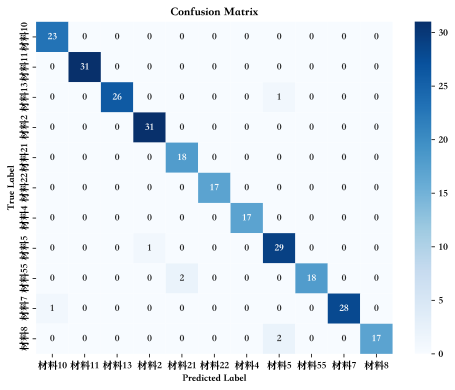

In [3]:
ss=pd.DataFrame()
ss['real']=le.inverse_transform(ytest)
ss['pred']=le.inverse_transform(ypreds)
# 计算每种材料分类的概率
for name in ss['real'].unique():
    count = len(ss[(ss['real']==name) & (ss['pred']==name)])
    total = len(ss[ss['real']==name])
    print(name,count/total,count,total)

from sklearn.metrics import confusion_matrix
import seaborn as sns
# 计算混淆矩阵
cm = confusion_matrix(ss['real'], ss['pred'])

# 获取所有唯一的标签（为了确保混淆矩阵的标签顺序）
labels = sorted(set(ss['real'].unique()) | set(ss['pred'].unique()))
# 绘制混淆矩阵
plt.rcParams['font.sans-serif'] = ['SimHei', 'Songti SC', 'STFangsong']
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()